<a href="https://colab.research.google.com/github/enoquerogerio/Credit_Approval_Analysis/blob/main/Credit_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Resultados da Árvore de Decisão ===
Acurácia: 0.8246

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       103
           1       0.80      0.90      0.85       125

    accuracy                           0.82       228
   macro avg       0.83      0.82      0.82       228
weighted avg       0.83      0.82      0.82       228


Matriz de Confusão:
[[ 75  28]
 [ 12 113]]


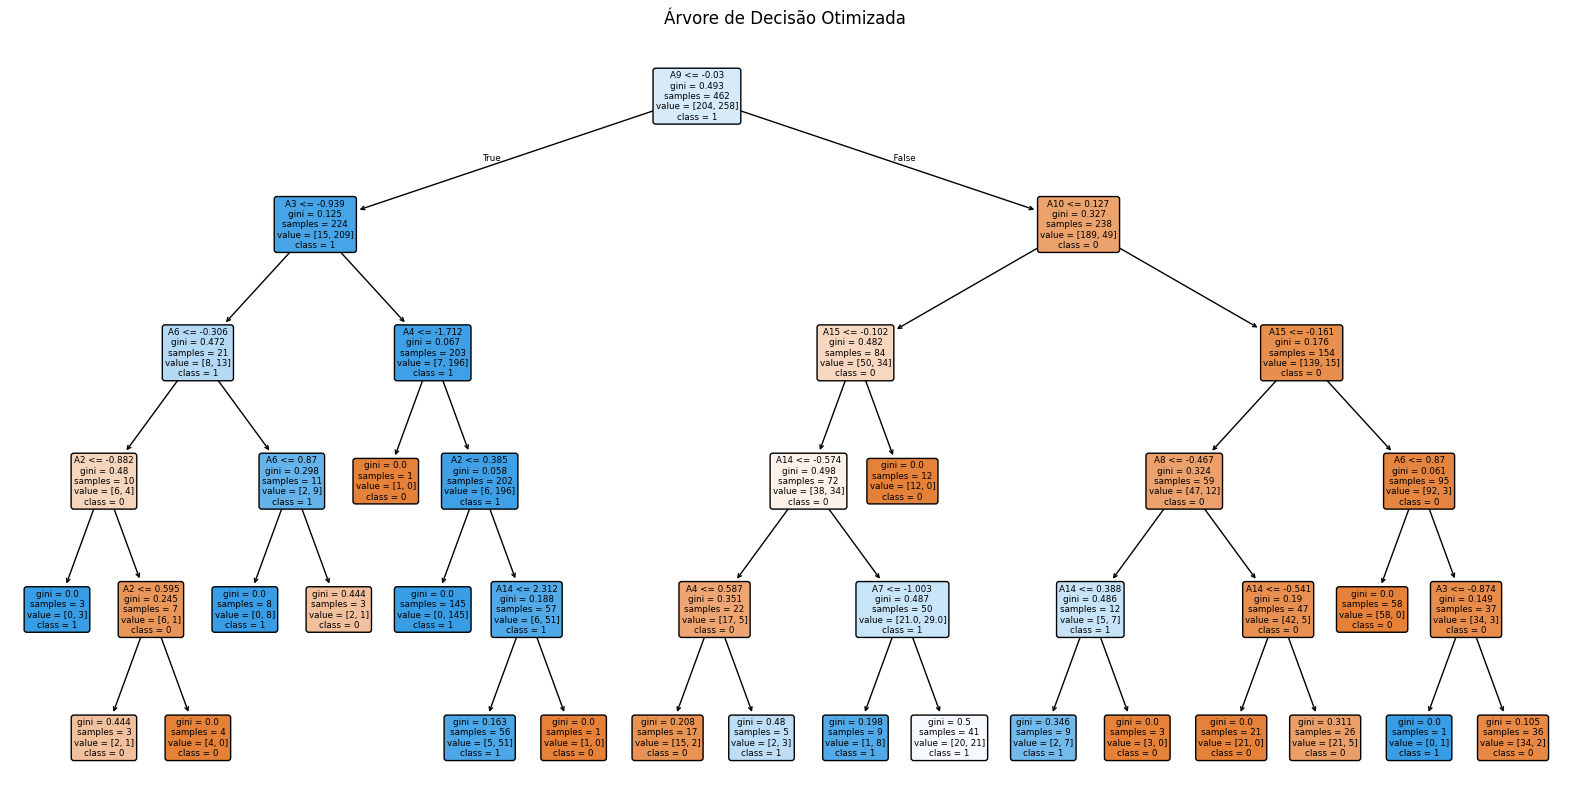

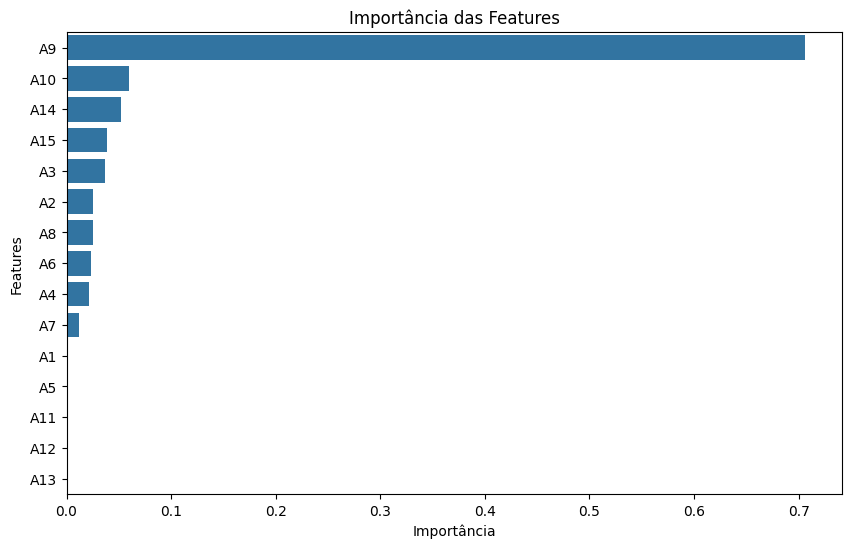


=== Comparação dos Modelos ===
Acurácia Árvore de Decisão: 0.8246
Acurácia Regressão Logística: 0.8377


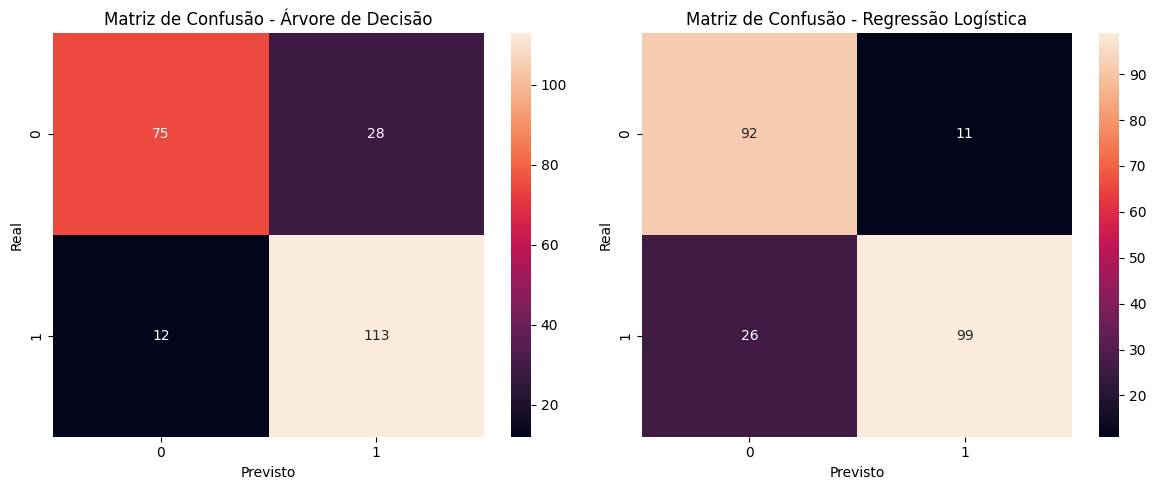

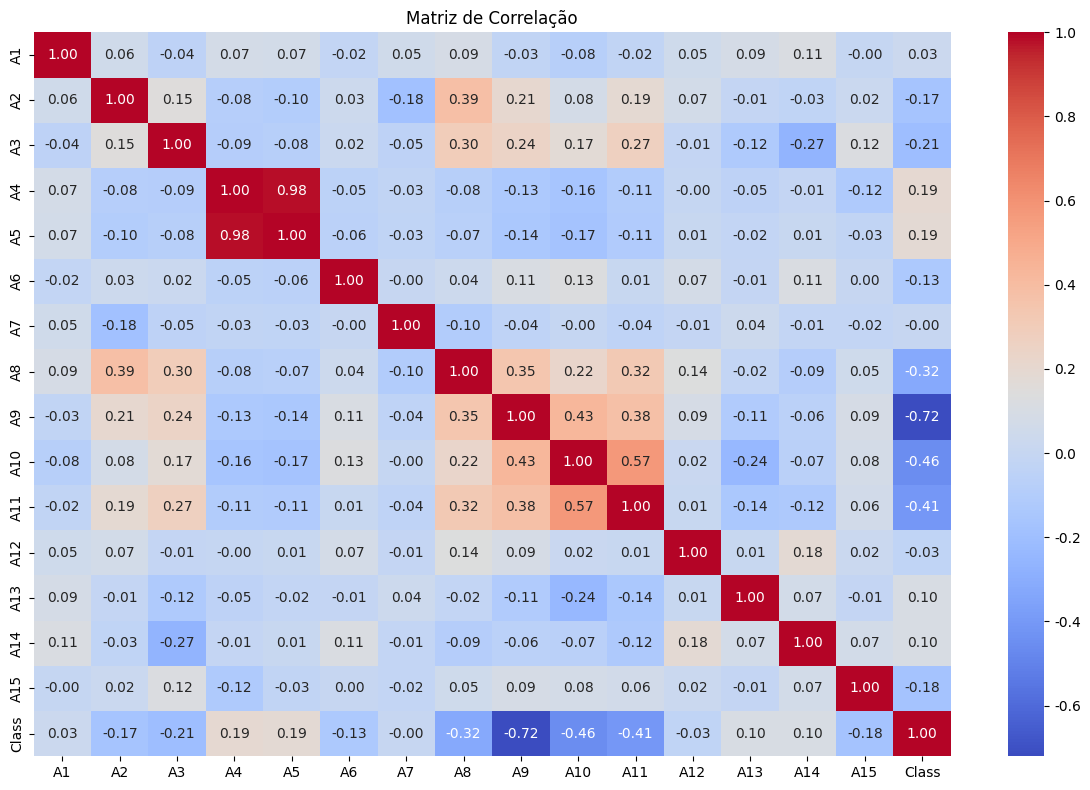

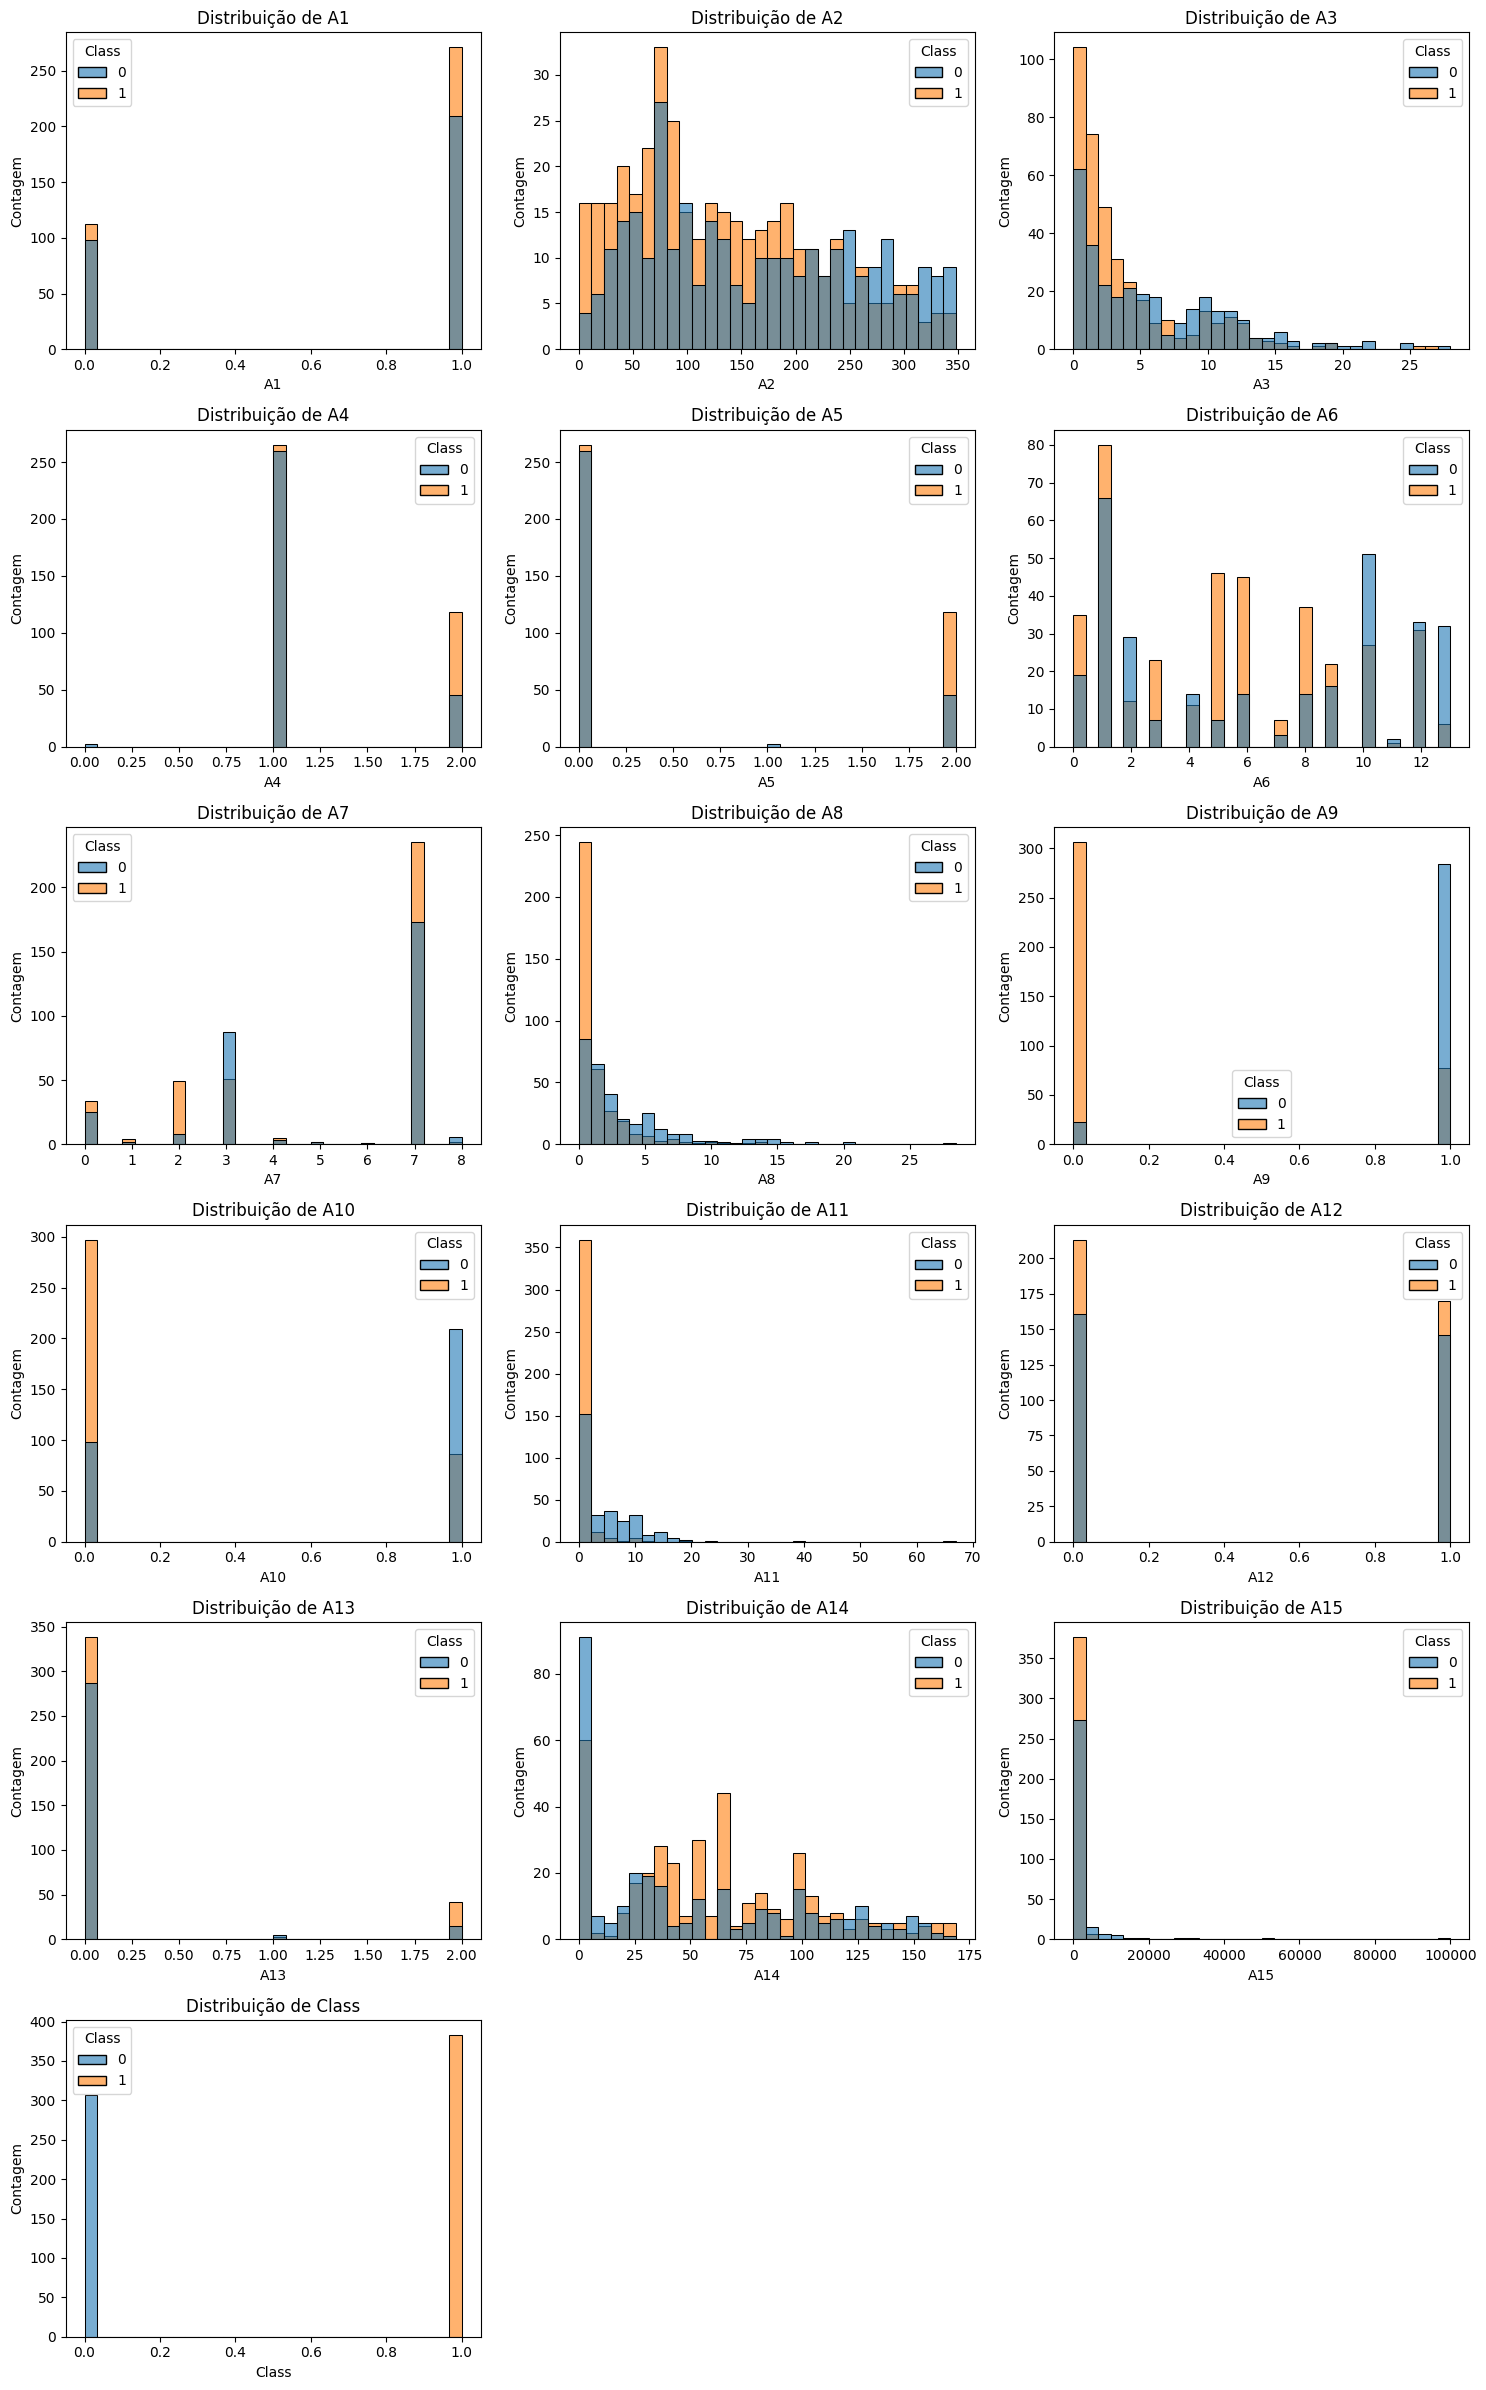

In [ ]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Configuração básica dos gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.unicode_minus'] = False

# Carregamento dos dados
file_path = "/content/crx.data"
column_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
                'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class']

df = pd.read_csv(file_path, header=None, names=column_names)
df.replace('?', np.nan, inplace=True)

# Pré-processamento
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

for col in df:
    if df[col].dtypes == 'object':
        df.loc[:, col] = df[col].fillna(df[col].value_counts().index[0])
        df[col] = LabelEncoder().fit_transform(df[col])

# Preparação dos dados
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Árvore de Decisão
dt_model = DecisionTreeClassifier(random_state=42)
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=5)
dt_grid.fit(X_train_scaled, y_train)

dt_pred = dt_grid.predict(X_test_scaled)

# Avaliação
print("=== Resultados da Árvore de Decisão ===")
print(f"Acurácia: {accuracy_score(y_test, dt_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, dt_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, dt_pred))

# Visualizações
plt.figure(figsize=(20,10))
plot_tree(dt_grid.best_estimator_, feature_names=X.columns, class_names=['0', '1'],
          filled=True, rounded=True)
plt.title("Árvore de Decisão Otimizada")
plt.show()

# Importância das features
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_grid.best_estimator_.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

plt.figure()
sns.barplot(data=importances, x='importance', y='feature')
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.ylabel("Features")
plt.show()

# Comparação com Regressão Logística
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_scaled, y_train)
log_pred = logreg.predict(X_test_scaled)

print("\n=== Comparação dos Modelos ===")
print(f"Acurácia Árvore de Decisão: {accuracy_score(y_test, dt_pred):.4f}")
print(f"Acurácia Regressão Logística: {accuracy_score(y_test, log_pred):.4f}")

# Matrizes de confusão
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('Matriz de Confusão - Árvore de Decisão')
ax1.set_xlabel('Previsto')
ax1.set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('Matriz de Confusão - Regressão Logística')
ax2.set_xlabel('Previsto')
ax2.set_ylabel('Real')

plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

# Histogramas
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numeric_features)
num_rows = (num_cols + 2) // 3  # Arredonda para cima

plt.figure(figsize=(15, num_rows * 4))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(data=df, x=col, hue='Class', bins=30, alpha=0.6)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
plt.tight_layout()
plt.show()

# Salvamento dos resultados
resultados = {
    'acuracia_arvore': float(accuracy_score(y_test, dt_pred)),
    'acuracia_regressao': float(accuracy_score(y_test, log_pred)),
    'melhores_parametros_arvore': dt_grid.best_params_,
    'importancia_features': importances.to_dict()
}

import json
with open('resultados_analise_credito.json', 'w') as f:
    json.dump(resultados, f, indent=4)